In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder

# Load and Explore dataset

## Load Dataset

In [2]:
df = pd.read_csv(r"C:\Users\USER\Downloads\archive (19)\Crop_Recommendation.csv")
df.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH_Value     2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [4]:
df.shape

(2200, 8)

In [5]:
df.isna().sum()

Nitrogen       0
Phosphorus     0
Potassium      0
Temperature    0
Humidity       0
pH_Value       0
Rainfall       0
Crop           0
dtype: int64

## Summary Statistics of the Dataset

In [6]:
df.describe()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [7]:
df.describe(include = 'object')

,Crop
count,2200
unique,22
top,Rice
freq,100


In [8]:
df.duplicated().sum()

0

In [9]:
df['Crop'].unique()

array(['Rice', 'Maize', 'ChickPea', 'KidneyBeans', 'PigeonPeas',
       'MothBeans', 'MungBean', 'Blackgram', 'Lentil', 'Pomegranate',
       'Banana', 'Mango', 'Grapes', 'Watermelon', 'Muskmelon', 'Apple',
       'Orange', 'Papaya', 'Coconut', 'Cotton', 'Jute', 'Coffee'],
      dtype=object)

## Detecting Outliers

In [10]:
def detect_outliers(df, threshold=1.5):
    """
    Detect outliers in a DataFrame using the IQR method.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (float): The multiplier for the IQR to define outlier boundaries.
        
    Returns:
        dict: A dictionary with column names as keys and counts of outliers as values.
    """
    # Automatically select numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialize a dictionary to store the count of outliers
    outlier_counts = {}
    
    for col in numeric_cols:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Count the number of outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = outliers.shape[0]
    
    return outlier_counts

# Detect outliers and print counts
outlier_counts = detect_outliers(df)
print("Number of outliers per column:")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

Number of outliers per column:
Nitrogen: 0
Phosphorus: 138
Potassium: 200
Temperature: 86
Humidity: 30
pH_Value: 57
Rainfall: 100


## VIsualizing Outliers

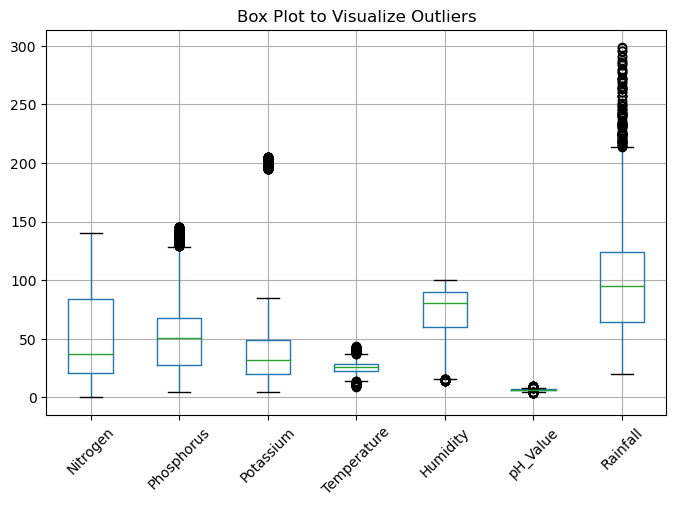

In [14]:
# Automatically select numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Box plot for each numeric column
df[numeric_cols].boxplot(figsize=(8, 5))
plt.title("Box Plot to Visualize Outliers")
plt.xticks(rotation=45)
plt.show()

From above we can wee that only `Nitrogen` feature doesn't have any outlier, while the rest has quite a number of iutlier that we will need to deal with later on

## Visualize the distribution of the features

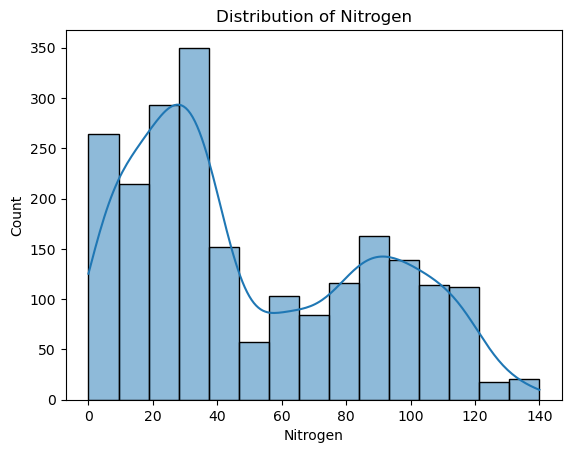

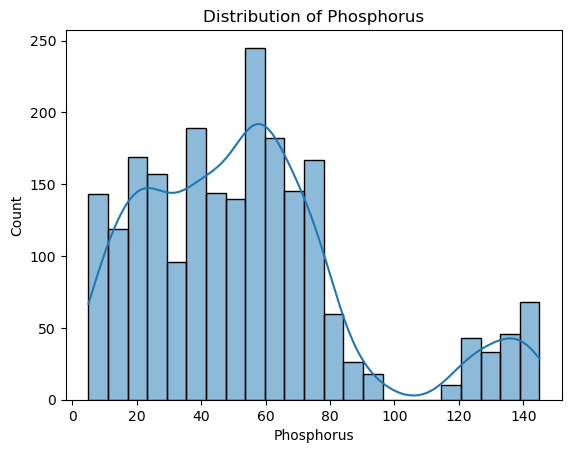

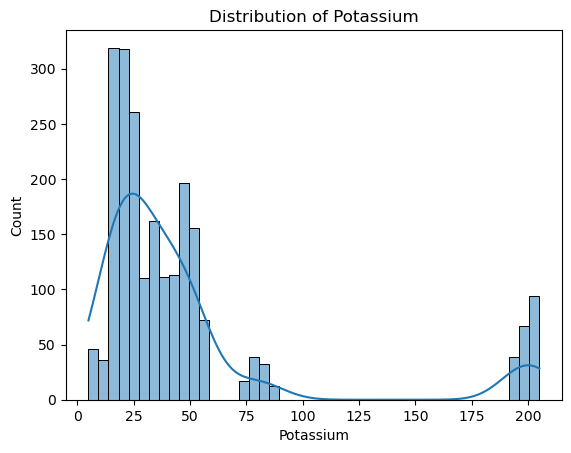

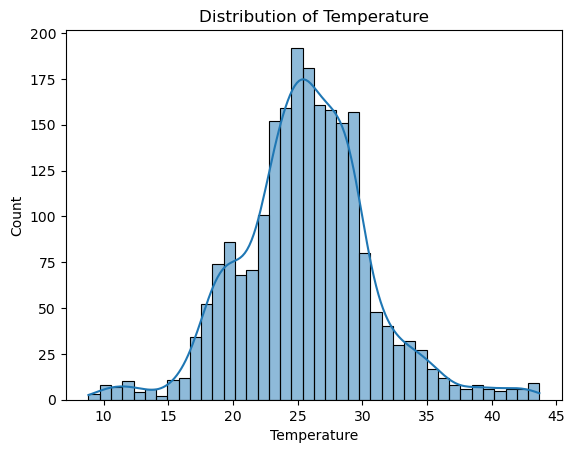

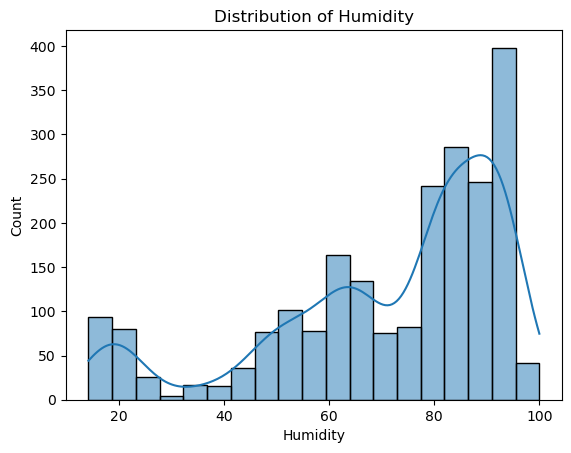

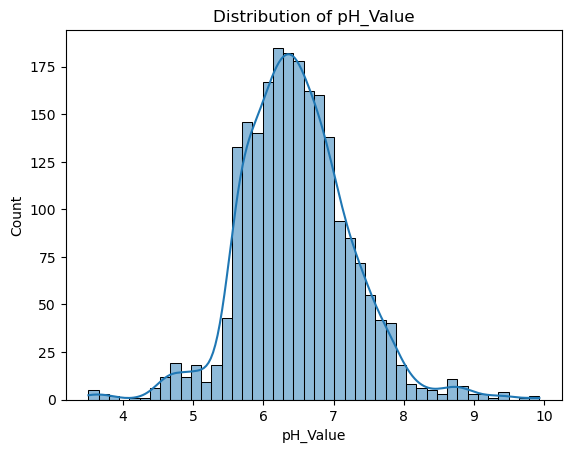

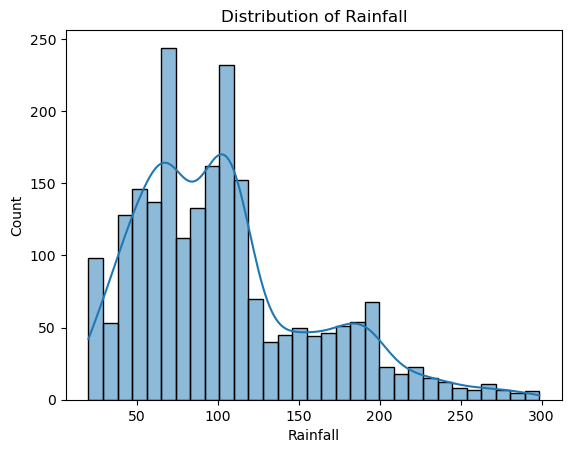

In [15]:
# Numerical features
numeric_features = df.select_dtypes(include=['number']).columns
for feature in numeric_features:
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()

## Check the Class Balance of the Target variable

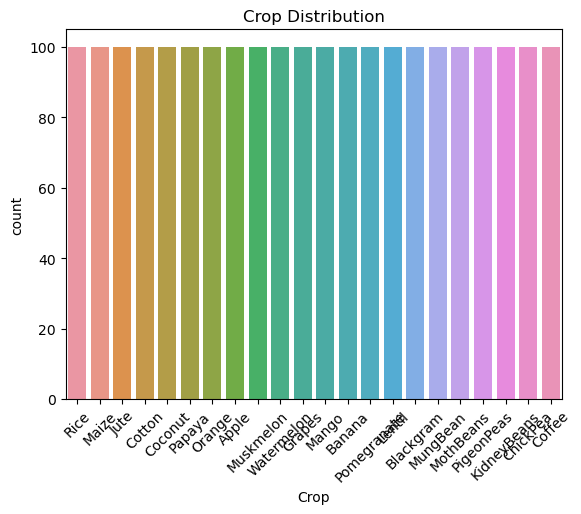

In [16]:
# Class balance
sns.countplot(x='Crop', data=df, order=df['Crop'].value_counts().index)
plt.title("Crop Distribution")
plt.xticks(rotation=45)
plt.show()

## Feature Correlation

In [17]:
# Calculate correlations for numeric columns
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Display the correlation matrix
print("Numerical Feature Correlations:")
correlation_matrix

Numerical Feature Correlations:


,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
Nitrogen,1.000000,-0.231460,-0.140512,0.026504,0.190688,0.096683,0.059020
Phosphorus,-0.231460,1.000000,0.736232,-0.127541,-0.118734,-0.138019,-0.063839
Potassium,-0.140512,0.736232,1.000000,-0.160387,0.190859,-0.169503,-0.053461
Temperature,0.026504,-0.127541,-0.160387,1.000000,0.205320,-0.017795,-0.030084
Humidity,0.190688,-0.118734,0.190859,0.205320,1.000000,-0.008483,0.094423
pH_Value,0.096683,-0.138019,-0.169503,-0.017795,-0.008483,1.000000,-0.109069
Rainfall,0.059020,-0.063839,-0.053461,-0.030084,0.094423,-0.109069,1.000000


### Correlation Analysis

The correlation matrix provides insights into the linear relationships between numerical features in the dataset:

1. **Key Observations**:
   - **Strong Positive Correlation**:
     - Phosphorus and Potassium (`0.736`): Indicates that higher levels of phosphorus are generally associated with higher levels of potassium.
   - **Moderate Negative Correlation**:
     - Phosphorus and Nitrogen (`-0.231`): Suggests that an increase in phosphorus might correspond to a slight decrease in nitrogen.
   - **Weak or Negligible Correlations**:
     - Most other feature pairs show low correlation values, indicating little to no linear relationship.

2. **Implications**:
   - **Feature Selection**:
     - Strongly correlated features (e.g., Phosphorus and Potassium) may lead to multicollinearity in linear models. Consider removing one of the features or using regularization techniques.

3. **Next Steps**:
   - Visualize relationships between key features (e.g., scatter plots for strongly correlated pairs) to confirm trends.

By understanding the numerical correlations, we can better prepare the dataset for predictive modeling and ensure that key relationships are leveraged effectively.

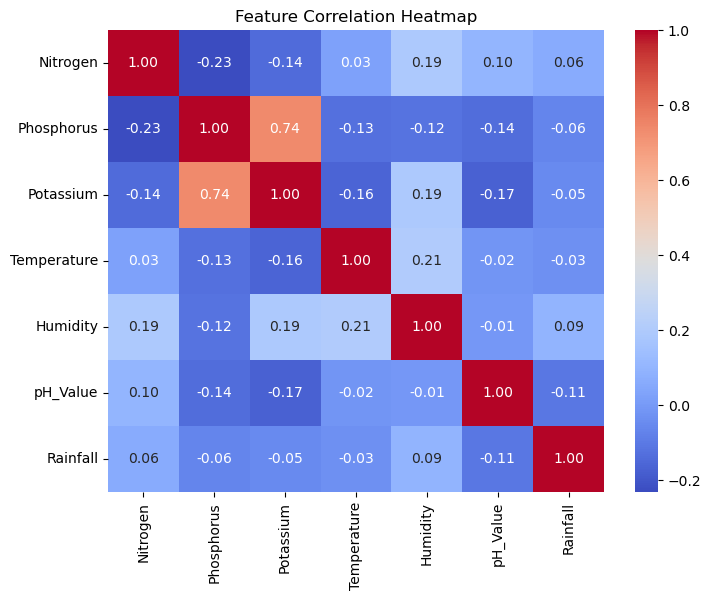

In [18]:
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Preprocessing
Outlier Handling, Addressing Multicolinearity, Scaling and Encoding, Train-Test-Split

## Outlier Handling

In [19]:
def remove_outliers(df, threshold=1.5):
    """
    Remove outliers from a DataFrame using the IQR method.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (float): The multiplier for the IQR to define outlier boundaries.
        
    Returns:
        pd.DataFrame: A new DataFrame with outliers removed.
    """
    # Automatically select numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Create a copy of the DataFrame to avoid modifying the original
    filtered_df = df.copy()
    
    for col in numeric_cols:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Remove rows with outliers
        filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]
    
    return filtered_df

# Remove outliers and return a cleaned DataFrame
df_cleaned = remove_outliers(df)
print(f"Original DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")

Original DataFrame shape: (2200, 8)
Cleaned DataFrame shape: (1768, 8)


## Encoding

In [21]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
df_cleaned[numeric_features] = scaler.fit_transform(df_cleaned[numeric_features])

encoder = LabelEncoder()
df_cleaned['Crop'] = encoder.fit_transform(df_cleaned['Crop'])
df_cleaned.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
0,0.928231,-0.126033,0.718184,-1.189446,0.545039,0.030913,2.174235,18
13,1.006304,0.492928,0.272680,-0.437164,0.547521,0.737749,1.808354,18
14,1.032328,0.227659,0.336323,-0.041045,0.483656,0.684397,2.312053,18
17,0.954255,-0.435513,0.463610,-0.490205,0.472392,0.717935,2.243143,18
20,0.902207,0.006602,0.272680,-1.082599,0.474987,-0.057939,1.812915,18


In [22]:
# Correct mapping
crop_mapping = dict(enumerate(encoder.classes_))  # Double-check this line!

# Convert the dictionary to a DataFrame
crop_mapping_df = pd.DataFrame(list(crop_mapping.items()), columns=['Label', 'Crop'])

# Display the DataFrame
print(crop_mapping_df.to_string(index=False))


 Label        Crop
     0      Banana
     1   Blackgram
     2    ChickPea
     3     Coconut
     4      Coffee
     5      Cotton
     6        Jute
     7 KidneyBeans
     8      Lentil
     9       Maize
    10       Mango
    11   MothBeans
    12    MungBean
    13   Muskmelon
    14      Orange
    15      Papaya
    16  PigeonPeas
    17 Pomegranate
    18        Rice
    19  Watermelon


## Train-Test-Split

In [23]:
# Features (X) and target (y)
X = df_cleaned.drop('Crop', axis=1)  # Drop the target column from features
y = df_cleaned['Crop']              # Extract the target column

# Perform a train-test split (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Scaling

In [24]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modeling

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Model training
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = classification_report(y_test, y_pred, output_dict=True)

# Display results
for model_name, report in results.items():
    print(f"{model_name}:\n", classification_report(y_test, y_pred))

Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.95      1.00      0.98        20
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       0.95      1.00      0.98        20
           7       1.00      1.00      1.00        20
           8       1.00      0.95      0.97        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       0.92      0.92      0.92        12
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        17
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00        20
          1

## Feature Importance Analysis

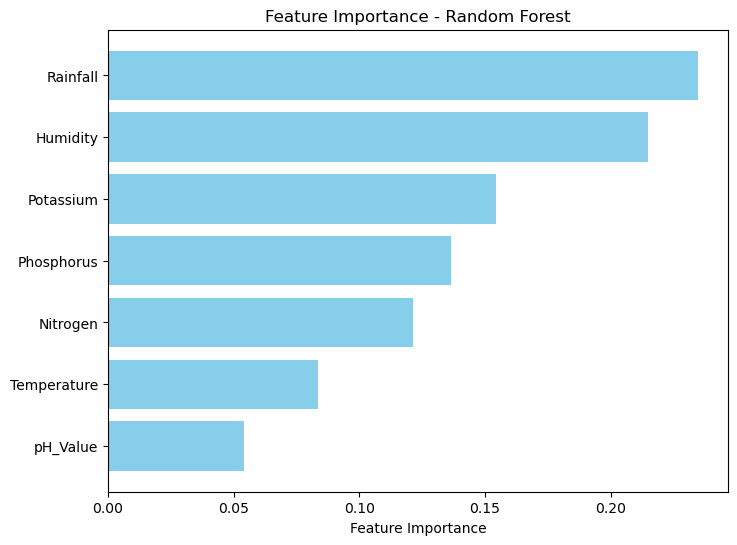

In [27]:
# Feature Importance for Random Forest
rf_model = models["Random Forest"]
feature_importances_rf = rf_model.feature_importances_
sorted_idx_rf = np.argsort(feature_importances_rf)

plt.figure(figsize=(8,6))
plt.barh(X.columns[sorted_idx_rf], feature_importances_rf[sorted_idx_rf], color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance - Random Forest")
plt.show()